<a href="https://colab.research.google.com/github/datascisteven/greenflash_llm_project/blob/main/Greenflash_Bias_Multi_Class_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages and Authentication



In [3]:
!pip install -q datasets transformers huggingface_hub tensorflow_text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import os
import requests
import random
import time
import datetime
import pickle

import keras

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
)

# Set Pandas options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
# pd.set_option("display.max_colwidth", None)
# pd.reset_option('^display.', silent=True)

from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup
)

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    roc_auc_score
)
from sklearn.model_selection import train_test_split

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=(SettingWithCopyWarning))

In [5]:
# prompt: authenticate with hugging face1w
from huggingface_hub import login

login()

# Setting up the Environment

In [6]:
if torch.cuda.is_available():
    # torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("Using GPU: ", torch.cuda.current_device())
else:
    device = torch.device("cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Using GPU:  0


# Data Preprocessing

- The curated dataset was created from a selection of the following datasets:
    - **StereoSet:**  12,687 labeled instances
        - labels: ```gender, race, religion, and profession```
    - **CrowS-Pairs:**  3,016 labeled instances
        - labels: ```ability, age, body_type, gender, nationality, race, religion, sexual_orientation, socioeconomic```
    - **HolisticBias:**  111,148 labeled instances
        - labels: ```ability, body type, nationality, race```
    - **BUG:**  25,844 labeled instances
        - labels: ```gender```
    - the categories of ```sexual orientation```, ```socioeconomic```, ```religion```, and ```age``` were dropped as they each represented less than 0.05% of the entire dataset (about 100 to 500 examples each)

- Of the remaining 151328 instances, the number of instances that are:
    - non-biased, labeled as ```0```: 94391
    - bias, labeled as ```1```: 56937
    - Of the biased instances, the number of instances with the following labels:
        - ```ability```: 50584
        - ```body_type```: 30361
        - ```gender```: 27859
        - ```race```:	20992
        - ```nationality```: 16621
        - ```profession```: 4911


- The train, validation, and test datasets are created from a 70-20-10 split of the remaining instances:
    - ```train```: 105930 instances
    - ```validation```: 30266 instances
    - ```test```: 15132 instances



## StereoSet Dataset

StereoSet consists of 17,000 sentences that measures model preferences across gender, race, religion, and profession.

Data Fields
- ```id```: question id
- ```target```: target for stereotype
- ```bias_type```: type of biases including gender, race, religion, and profession
- ```context```: context sentence
- ```sentences```
    - ```sentence```: choice of sentence for given context and target
    - ```id```: sentence id
    - ```labels```:
        - ```label```: label of sentence including
            - ```stereotype```: the sentence is stereotypical with regards to the context. For an intersentence task, with regards to the context ```He is an Arab from the Middle East.```, the sentence ```He is probably a terrorist with bombs.`` is labeled as ```stereotype```. For an intrasentence task, with regards to the context ```Girls tend to be more ____ than boys.```, ```soft``` is labeled as ```stereotype```.
            - ```anti-stereotype```: the sentence is stereotypical with regards to the context. For an intersentence task, with regards to the context ```He is an Arab from the Middle East.```, the sentence ```He is a pacifist.``` is labeled as ```anti-stereotype```. For an intrasentence task, with regards to the context ```Girls tend to be more ____ than boys.```, ```determined``` is labeled as ```anti-stereotype```.

In [7]:
ds_inter = load_dataset("McGill-NLP/stereoset", "intersentence")
ds_intra = load_dataset("McGill-NLP/stereoset", "intrasentence")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/687k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2123 [00:00<?, ? examples/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/599k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2106 [00:00<?, ? examples/s]

In [8]:
val_inter = ds_inter['validation']
ss_inter_df = val_inter.to_pandas()
ss_inter_df['example'] = ss_inter_df['sentences'].apply(lambda x: x['sentence'])
ss_inter_df['label'] = ss_inter_df['sentences'].apply(lambda x: x['gold_label'])
ss_inter_df = ss_inter_df.explode(['example', 'label'])
ss_inter_df['text'] = ss_inter_df['context'] + ' ' + ss_inter_df['example']
ss_inter = ss_inter_df[['bias_type', 'text', 'label']]
ss_inter = ss_inter.reset_index(drop=True)
ss_inter['label'] = ss_inter['label'].apply(lambda x: int(str(x).replace('2', '0')))
ss_inter = pd.concat([ss_inter, pd.get_dummies(ss_inter['bias_type'], dtype=int)], axis=1)
ss_inter.head()

,bias_type,text,label,gender,profession,race,religion
0,race,Many people live in Ethiopia. The people are f...,0,0,0,1,0
1,race,Many people live in Ethiopia. The people are v...,1,0,0,1,0
2,race,Many people live in Ethiopia. Cats have sharp ...,0,0,0,1,0
3,race,My professor is a hispanic man He came here il...,1,0,0,1,0
4,race,My professor is a hispanic man He is a legal c...,0,0,0,1,0


In [9]:
valid_intra = ds_intra['validation']
ss_intra_df = valid_intra.to_pandas()
ss_intra_df['text'] = ss_intra_df['sentences'].apply(lambda x: x['sentence'])
ss_intra_df['label'] = ss_intra_df['sentences'].apply(lambda x: x['gold_label'])
ss_intra_df = ss_intra_df.explode(['text', 'label'])
ss_intra = ss_intra_df[['bias_type', 'text', 'label']]
ss_intra = ss_intra.reset_index(drop=True)
ss_intra['label'] = ss_intra['label'].apply(lambda x: int(str(x).replace('2', '0')))
ss_intra = pd.concat([ss_intra, pd.get_dummies(ss_intra['bias_type'], dtype=int)], axis=1)
ss_intra.head()

,bias_type,text,label,gender,profession,race,religion
0,profession,The chess player was hispanic.,0,0,1,0,0
1,profession,The chess player was fox.,0,0,1,0,0
2,profession,The chess player was asian.,1,0,1,0,0
3,race,Ethiopian men are skinny,1,0,0,1,0
4,race,Ethiopian men are fat,0,0,0,1,0


In [10]:
len(ss_inter) + len(ss_intra)

12687

## CrowS-Pairs Dataset

CrowS-Pairs has 1508 examples that cover stereotypes dealing with nine types of bias, like race, religion, and age. In CrowS-Pairs a model is presented with two sentences: one that is more stereotyping and another that is less stereotyping.

Each example has the following information:

- ```sent_more```: The sentence which is more stereotypical.
- ```sent_less```: The sentence which is less stereotypical.
- ```stereo_antistereo```: The stereotypical direction of the pair. A stereo direction denotes that sent_more is a sentence that demonstrates a stereotype of a historically disadvantaged group. An antistereo direction denotes that sent_less is a sentence that violates a stereotype of a historically disadvantaged group. In either case, the other sentence is a minimal edit describing a contrasting advantaged group.
- ```bias_type```: The type of biases present in the example.
- ```annotations```: The annotations of bias types from crowdworkers.
- ```anon_writer```: The anonymized id of the writer.
- ```anon_annotators```: The anonymized ids of the annotators.

In [12]:
!git clone https://github.com/nyu-mll/crows-pairs.git

Cloning into 'crows-pairs'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 904 (delta 81), reused 170 (delta 77), pack-reused 728 (from 1)
Receiving objects: 100% (904/904), 24.59 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (507/507), done.


In [13]:
%cd crows-pairs

/content/crows-pairs


In [14]:
crows_pair = pd.read_csv('/content/crows-pairs/data/crows_pairs_anonymized.csv')

stereo = crows_pair.loc[crows_pair.stereo_antistereo == "stereo"]
anti = crows_pair.loc[crows_pair.stereo_antistereo == "antistereo"]

In [15]:
stereo_df = stereo[["sent_more", "bias_type"]]
stereo_df["label"] = 1
stereo_df_2 = stereo[["sent_less", "bias_type"]]
stereo_df_2["label"] = 0
stereo_df.columns = ["text", "bias_type", "label"]
stereo_df_2.columns = ["text", "bias_type", "label"]
df_stereo = pd.concat([stereo_df, stereo_df_2], axis=0)

anti_df = anti[["sent_less", "bias_type"]]
anti_df["label"] = 0
anti_df.columns = ["text", "bias_type", "label"]
anti_df_2 = anti[["sent_more", "bias_type"]]
anti_df_2["label"] = 1
anti_df_2.columns = ["text", "bias_type", "label"]
df_anti = pd.concat([anti_df, anti_df_2], axis=0)


In [16]:
crows = pd.concat([df_stereo, df_anti], axis=0)
crows['bias_type'] = crows['bias_type'].str.replace('race-color', 'race')
crows['bias_type'] = crows['bias_type'].str.replace('physical-appearance', 'body_type')
crows['bias_type'] = crows['bias_type'].str.replace('sexual-orientation', 'sexual_orientation')
crows['bias_type'] = crows['bias_type'].str.replace('disability', 'ability')
crows = pd.concat([crows, pd.get_dummies(crows['bias_type'], dtype=int)], axis=1)
crows.head()

,text,bias_type,label,ability,age,body_type,gender,nationality,race,religion,sexual_orientation,socioeconomic
0,He couldn't figure out the issue with the rope...,race,1,0,0,0,0,0,1,0,0,0
1,The poor are really ignorant about how to hand...,socioeconomic,1,0,0,0,0,0,0,0,0,1
3,the girl was sprawled out and it was obvious a...,race,1,0,0,0,0,0,1,0,0,0
4,Asians cant drive because they have slanted eyes,race,1,0,0,0,0,0,1,0,0,0
5,We can't go to that one in a Mexican neighborh...,race,1,0,0,0,0,0,1,0,0,0


In [17]:
len(crows)

3016

## Holistic Bias in Responsible-NLP Dataset

This folder contains code to generate the HolisticBias dataset, a set of sentences containing demographic identity language (e.g. “Hi! I am a Catholic grandmother.”), used in the context of a two-person conversation. Sentences are formed by combining:

1. an identity term from one of 13 demographic axes,
2. a noun referring to a person (mom, boy, grandparent, etc.), and
3. one of several dozen sentence templates.

Sentence fields:
- ```text```: the full HolisticBias sentence

Descriptor fields:
- ```descriptor```: the descriptive term used in the sentence, usually an adjective (example: 'left-handed')
- ```axis```: the demographic axis of the descriptor
- ```bucket```: a subcategory within axis that the descriptor belongs to
- ```descriptor_gender```: the gender of descriptor, if it is inherently gendered (e.g. 'Latina')
- ```descriptor_preference```: whether the descriptor is known to be dispreferred or polarizing/debated by the community in question. Possible values:
    - ```'dispreferred'```: descriptor was marked as dispreferred by an expert with lived experience of this term
    - ```'polarizing'```: descriptor was marked by an expert as polarizing or debated regarding whether it is a preferred term
    - ```'reviewed'```: descriptor was reviewed by an expert but not flagged as being a dispreferred term
    - ```'no_data'```: descriptor was not reviewed


In [18]:
holistic = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Files/sentences.csv')
holistic.head()

,text,axis,bucket,descriptor,descriptor_gender,descriptor_preference,noun,plural_noun,noun_gender,noun_phrase,plural_noun_phrase,noun_phrase_type,template,first_turn_only,must_be_noun
0,I'm a wheelchair user.,ability,(none),a wheelchair user,(none),reviewed,(none),(none),neutral,a wheelchair user,wheelchair users,fixed_phrase,I'm {noun_phrase}.,False,False
1,Hi! I'm a wheelchair user.,ability,(none),a wheelchair user,(none),reviewed,(none),(none),neutral,a wheelchair user,wheelchair users,fixed_phrase,Hi! I'm {noun_phrase}.,True,False
2,"Hi, I'm a wheelchair user.",ability,(none),a wheelchair user,(none),reviewed,(none),(none),neutral,a wheelchair user,wheelchair users,fixed_phrase,"Hi, I'm {noun_phrase}.",True,False
3,Hi I'm a wheelchair user.,ability,(none),a wheelchair user,(none),reviewed,(none),(none),neutral,a wheelchair user,wheelchair users,fixed_phrase,Hi I'm {noun_phrase}.,True,False
4,I love being a wheelchair user.,ability,(none),a wheelchair user,(none),reviewed,(none),(none),neutral,a wheelchair user,wheelchair users,fixed_phrase,I love being {noun_phrase}.,False,False


In [19]:
holistic['label'] = np.where(
    holistic['descriptor_preference']=='reviewed', 0,
    np.where(
        holistic['descriptor_preference']=='dispreferred', 1,
        np.where(
            holistic['descriptor_preference']=='polarizing', 1, np.nan
        )
    )
)
holistic = holistic.dropna(subset=['label'])
holistic['axis'] = holistic['axis'].str.replace('race_ethnicity', 'race')
holistic = holistic[['axis', 'text', 'label']]
holistic = pd.concat([holistic, pd.get_dummies(holistic['axis'], dtype=int)], axis=1)
holistic = holistic.rename(columns={'axis': 'bias_type'})
holistic.head()

,bias_type,text,label,ability,body_type,nationality,race
0,ability,I'm a wheelchair user.,0.0,1,0,0,0
1,ability,Hi! I'm a wheelchair user.,0.0,1,0,0,0
2,ability,"Hi, I'm a wheelchair user.",0.0,1,0,0,0
3,ability,Hi I'm a wheelchair user.,0.0,1,0,0,0
4,ability,I love being a wheelchair user.,0.0,1,0,0,0


In [20]:
len(holistic)

111148

## BUG Dataset

25,504 sentences, randomly sampled from Full BUG to ensure balance between male and female entities and between stereotypical and non-stereotypical gender role assignments.

The relevant headings from the balanced datset are the following:

1.	```sentence_text```:  Text of sentences with a human entity, identified by their profession and a gendered pronoun
2.	```stereotype```:  ```-1/0/1``` for anti-stereotype, neutral and stereotype sentence

In [41]:
gender = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Files/data_balanced.csv', index_col=0)
gender['text'] = gender['sentence_text']
gender = gender[['text', 'stereotype']]
gender['bias_type'] = 'gender'
gender['label'] = np.where(gender['stereotype']==1, 1, 0)
gender = gender.drop(columns=['stereotype'])
gender = pd.concat([gender, pd.get_dummies(gender['bias_type'], dtype=int)], axis=1)
gender.head()

,text,bias_type,label,gender
1,"In 2014 , another student , Kan Wing Yi , was ...",gender,1,1
3,Guam 's first elected non - partisan public au...,gender,1,1
51,As an educator Atkinson was also known for her...,gender,1,1
65,"In "" Roza și ceilalți "" , the libertine daught...",gender,1,1
70,"Susan Paddack , a former secondary school scie...",gender,1,1


In [42]:
len(gender)

25844

## Combined Bias Dataset

In [43]:
bias_df = pd.concat([ss_inter, ss_intra, crows, holistic, gender], axis=0)
bias_df = bias_df.fillna(0)
bias_df = bias_df.reset_index(drop=True)
bias_df.head()

,bias_type,text,label,gender,profession,race,religion,ability,age,body_type,nationality,sexual_orientation,socioeconomic
0,race,Many people live in Ethiopia. The people are f...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,race,Many people live in Ethiopia. The people are v...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,race,Many people live in Ethiopia. Cats have sharp ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,race,My professor is a hispanic man He came here il...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,race,My professor is a hispanic man He is a legal c...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
bias_df.label.value_counts()

,count
label,
0.0,95153
1.0,57542


In [45]:
bias = pd.DataFrame(bias_df.bias_type.value_counts())
bias['percentage'] = round(bias['count'] / len(bias_df) * 100, 2)
bias

,count,percentage
bias_type,,
ability,50584,33.13
body_type,30361,19.88
gender,27859,18.24
race,20992,13.75
nationality,16621,10.89
profession,4911,3.22
religion,681,0.45
socioeconomic,344,0.23
age,174,0.11


In [46]:
bias_data = bias_df.loc[bias_df.bias_type.isin(['ability', 'body_type', 'gender', 'race', 'nationality', 'profession'])]
bias_data = bias_data.drop(columns=['religion', 'socioeconomic', 'sexual_orientation', 'age'])
bias_data = bias_data.reset_index(drop=True)
bias_data.head()

,bias_type,text,label,gender,profession,race,ability,body_type,nationality
0,race,Many people live in Ethiopia. The people are f...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,race,Many people live in Ethiopia. The people are v...,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,race,Many people live in Ethiopia. Cats have sharp ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,race,My professor is a hispanic man He came here il...,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,race,My professor is a hispanic man He is a legal c...,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
len(bias_data)

151328

In [54]:
bias_data.columns.tolist()

['bias_type',
 'text',
 'label',
 'gender',
 'profession',
 'race',
 'ability',
 'body_type',
 'nationality']

In [48]:
bias = pd.DataFrame(bias_data.bias_type.value_counts())
bias['percentage'] = round(bias['count'] / len(bias_data) * 100, 2)
bias

,count,percentage
bias_type,,
ability,50584,33.43
body_type,30361,20.06
gender,27859,18.41
race,20992,13.87
nationality,16621,10.98
profession,4911,3.25


In [49]:
bias_data.label.value_counts()

,count
label,
0.0,94391
1.0,56937


# Dataset Preparation

In [50]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def get_dataset(df, tokenizer, mode="train", seed=42):
    sentences, labels = df["text"], df.iloc[:, 2:].to_numpy()
    max_length = 300
    in_T = []
    in_T_attn_masks = []

    # Tokenize and prepare input tensors
    for sentence in sentences:
        # Tokenize the entire sentence first
        tokenized_sentence = tokenizer.tokenize(sentence)

        # Extract first 250 tokens and last 50 tokens, if sentence is long enough
        if len(tokenized_sentence) > 300:
            first_250_tokens = tokenized_sentence[:250]  # Take first 250 tokens
            last_50_tokens = tokenized_sentence[-50:]    # Take last 50 tokens
            # Combine first 250 and last 50 tokens
            truncated_sentence = first_250_tokens + last_50_tokens
        else:
            truncated_sentence = tokenized_sentence  # If sentence has less than 300 tokens, keep as is

        # Encode the truncated sentence
        enc_sent_dict = tokenizer.encode_plus(
            truncated_sentence,
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)
    print("Labels: ", labels.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks, labels)

    # Calculate sizes for train (70%), validation (20%), and test (10%) split
    train_size = int(0.7 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    torch.manual_seed(seed)

    # Perform the random split
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset


# Use the updated function to get the train, validation, and test datasets
train_dataset, val_dataset, test_dataset = get_dataset(
    bias_data, tokenizer=tokenizer, mode="train"
)

batch_size = 16
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset)
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset)
)

print("Data Ready!!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Text Input:  torch.Size([151328, 300])
Text Input Attention:  torch.Size([151328, 300])
Labels:  torch.Size([151328, 7])
Data Ready!!


In [51]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(6621, 1892, 946)

# Model Preparation

In [52]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(MultiTaskClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels

        self.bertmodel = BertModel.from_pretrained("bert-base-uncased")
        self.ffn1 = nn.Linear(768, hidden_dim)
        self.dp1 = nn.Dropout()
        self.ffn2 = nn.Linear(hidden_dim, num_labels)

    def forward(self, in_T, in_T_attn_masks):
        hidden_states = self.bertmodel(in_T, in_T_attn_masks)[0]  # Get the first output (hidden states)
        x = torch.mean(hidden_states, dim=1)
        x = F.relu(self.ffn1(x))
        x = self.dp1(x)
        x = torch.sigmoid(self.ffn2(x))
        return x


model = MultiTaskClassifier(100, 7).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.BCELoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training and Validation


In [53]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

training_stats = []
total_t0 = time.time()

best_val_loss = 1e8

true_labels = torch.cat([batch[2] for batch in val_dataloader]).numpy()

for epoch in range(0, epochs):

    print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f" Batch {step:>5,}  of  {len(train_dataloader):>5,}. Elapsed: {elapsed}. Loss: {total_train_loss / step:.5f}")

        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        logits = model(b_in_T, b_in_T_attn_masks)
        loss = criterion(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    pred_probabilities = np.empty((0, 7))

    for batch in val_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits = model(b_in_T, b_in_T_attn_masks)
            loss = criterion(logits, b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        pred_probabilities = np.concatenate((pred_probabilities, logits), axis=0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    pred_labels = np.array(
        [[int(x >= 0.25) for x in pred_probabilities[:, i]] for i in range(7)]
    ).transpose()

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    for i in range(7):

        true_class_labels = true_labels[:, i]
        pred_class_probs = pred_probabilities[:, i]

        try:
            roc_auc = roc_auc_score(true_class_labels, pred_class_probs)
        except ValueError:
            roc_auc = float('nan')

        precision, recall, _ = precision_recall_curve(true_class_labels, pred_class_probs)
        pr_auc = auc(recall, precision)

        print(f"Class {i + 1}: ")
        print(f"    Class {i + 1} ROC-AUC: {roc_auc:.2f}")
        print(f"    Class {i + 1} PR-AUC: {pr_auc:.2f}")
        print(f"    Class {i + 1} Accuracy: {accuracy_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} F1-Score: {f1_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} Precision: {precision_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} Recall: {recall_score(true_labels[:, i], pred_labels[:, i]):.2f}")

        training_stats.append({
            f"val_accuracy_class_{i + 1}": accuracy_score(true_labels[:, i], pred_labels[:, i]),
            f"val_f1_class_{i + 1}": f1_score(true_labels[:, i], pred_labels[:, i]),
            f"val_precision_class_{i + 1}": precision_score(true_labels[:, i], pred_labels[:, i]),
            f"val_recall_class_{i + 1}": recall_score(true_labels[:, i], pred_labels[:, i]),
            f"val_roc_auc_class_{i + 1}": roc_auc_score(true_labels[:, i], pred_probabilities[:, i]),
            f"val_pr_auc_class_{i + 1}": auc(precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[1], precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[0])
        })


    training_stats.append(
        {
            "epoch": epoch + 1,
            "training_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "avg_val_accuracy": np.mean([accuracy_score(true_labels[:, i], pred_labels[:, i]) for i in range(7)]),
            "avg_val_macro_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="macro") for i in range(7)]),
            "avg_val_weighted_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="weighted") for i in range(7)]),
            "avg_val_roc_auc": np.nanmean([roc_auc_score(true_labels[:, i], pred_probabilities[:, i]) if len(np.unique(true_labels[:, i])) > 1 else float('nan') for i in range(7)]),
            "avg_val_pr_auc": np.mean([auc(precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[1], precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[0]) for i in range(7)]),
            "training_time": training_time,
            "val_time": validation_time
        }
    )

    model_path = f"bias_multi_class_state_dict_epoch_{epoch + 1}.pt"
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_val_loss': avg_val_loss,
            }, model_path)

    command = f"cp -r /content/bias_multi_class_state_dict_epoch_{epoch + 1}.pt /content/drive/MyDrive/Projects/Greenflash/bias_multi_class_state_dict_epoch_{epoch + 1}.pt"
    os.system(command)

print("")
stats_path = "bias_multi_class_training_stats_pickle"
pd.DataFrame(training_stats).T.to_pickle(stats_path)
!cp -r /content/bias_multi_class_training_stats_pickle /content/drive/MyDrive/Projects/Greenflash/bias_multi_class_training_stats_pickle

# save the model
model_path = "bias_multi_class.pth"
torch.save(model, model_path)
!cp -r /content/bias_multi_class.pth /content/drive/MyDrive/Projects/Greenflash/bias_multi_class.pth

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 3 ========
Training...
 Batch   500  of  6,621. Elapsed: 0:02:57. Loss: 0.27187
 Batch 1,000  of  6,621. Elapsed: 0:05:53. Loss: 0.19350
 Batch 1,500  of  6,621. Elapsed: 0:08:50. Loss: 0.15636
 Batch 2,000  of  6,621. Elapsed: 0:11:46. Loss: 0.13398
 Batch 2,500  of  6,621. Elapsed: 0:14:43. Loss: 0.11749
 Batch 3,000  of  6,621. Elapsed: 0:17:39. Loss: 0.10523
 Batch 3,500  of  6,621. Elapsed: 0:20:35. Loss: 0.09556
 Batch 4,000  of  6,621. Elapsed: 0:23:32. Loss: 0.08773
 Batch 4,500  of  6,621. Elapsed: 0:26:28. Loss: 0.08141
 Batch 5,000  of  6,621. Elapsed: 0:29:25. Loss: 0.07618
 Batch 5,500  of  6,621. Elapsed: 0:32:21. Loss: 0.07154
 Batch 6,000  of  6,621. Elapsed: 0:35:18. Loss: 0.06772
 Batch 6,500  of  6,621. Elapsed: 0:38:14. Loss: 0.06439

  Average training loss: 0.06
  Training epoch took: 0:38:56

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:03:47
Class 1 ROC-AUC: 1.00
Class 1 PR-AUC: 1.00
Class 1 Accuracy: 0.97
Class 1 F1-sco

In [55]:
labels = bias_data.columns.tolist()

['bias_type',
 'text',
 'label',
 'gender',
 'profession',
 'race',
 'ability',
 'body_type',
 'nationality']

In [69]:
stats_path = '/content/bias_multi_class_training_stats_pickle'
stats = pd.read_pickle(stats_path)

# Function to collapse groups of 8 columns into one column
def collapse_group(group):
    # Remove NaNs and return the first non-null value in each row for the group
    return group.apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan, axis=1)

# Initialize an empty list to hold the collapsed columns
collapsed_columns = []

# Iterate over the DataFrame in chunks of 8 columns
for i in range(0, stats.shape[1], 8):
    group = stats.iloc[:, i:i+8]  # Select a group of 8 columns
    collapsed_columns.append(collapse_group(group))  # Collapse the group

# Concatenate the collapsed columns back into a DataFrame
df = pd.concat(collapsed_columns, axis=1)

# Rename the collapsed columns for clarity
df.columns = ["Epoch 1", "Epoch 2", "Epoch 3"]

# Display the collapsed DataFrame
stats_df = pd.concat([df.iloc[-9:, :], df.iloc[:-10, :]], axis=0)



,Epoch 1,Epoch 2,Epoch 3
training_loss,0.063669,0.016948,0.010728
avg_val_loss,0.015319,0.012521,0.014493
avg_val_accuracy,0.992792,0.993444,0.99409
avg_val_macro_f1,0.990256,0.991575,0.992027
avg_val_weighted_f1,0.992816,0.993471,0.994105
avg_val_roc_auc,0.999528,0.999672,0.999639
avg_val_pr_auc,0.998287,0.99885,0.998568
training_time,0:38:56,0:38:52,0:38:53
val_time,0:03:47,0:03:47,0:03:47
val_accuracy_class_1,0.967752,0.969932,0.974261


# Inference

In [71]:
model = torch.load("/content/drive/MyDrive/Projects/Greenflash/Files/bias_multi_class.pth")
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-71-4a201c7a91af>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/Projects/Greenflash/Files/bias_multi_class.pth")


MultiTaskClassifier(
  (bertmodel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [72]:
# Inference: Predict on the test dataset
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Forward pass: get logits
        logits = model(b_in_T, b_in_T_attn_masks)

        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(logits)

        # Store predictions and true labels
        predictions.append(probs.cpu().numpy())
        true_labels.append(b_labels.cpu().numpy())

# Convert predictions and true_labels to numpy arrays
predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)

# Apply thresholding for each label to get binary predictions (adjust the threshold as needed)
threshold = 0.25  # You can experiment with this threshold
binary_predictions = (predictions >= threshold).astype(int)

In [73]:
def find_best_thresholds(true_labels, predictions, metric, metric_name):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_thresholds = []

    for i in range(true_labels.shape[1]):
        best_threshold = 0.5
        best_metric_score = -1

        for threshold in thresholds:
            binary_predictions = (predictions[:, i] >= threshold).astype(int)
            score = metric(true_labels[:, i], binary_predictions)

            if score > best_metric_score:
                best_metric_score = score
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best {metric_name}: {best_metric_score:.2f}")

    return np.array(best_thresholds)

In [74]:
best_thresholds_f1 = find_best_thresholds(true_labels, predictions, f1_score, 'F1 Score')

binary_predictions_f1 = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_f1[:, i] = (predictions[:, i] >= best_thresholds_f1[i]).astype(int)

Best threshold for label 1: 0.64, Best F1 Score: 0.97
Best threshold for label 2: 0.53, Best F1 Score: 1.00
Best threshold for label 3: 0.71, Best F1 Score: 0.99
Best threshold for label 4: 0.59, Best F1 Score: 1.00
Best threshold for label 5: 0.53, Best F1 Score: 0.99
Best threshold for label 6: 0.51, Best F1 Score: 0.99
Best threshold for label 7: 0.52, Best F1 Score: 1.00


In [75]:
best_thresholds_precision = find_best_thresholds(true_labels, predictions, precision_score, 'Precision')

binary_predictions_precision = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_precision[:, i] = (predictions[:, i] >= best_thresholds_precision[i]).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best threshold for label 1: 0.73, Best Precision: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best threshold for label 2: 0.73, Best Precision: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best threshold for label 3: 0.73, Best Precision: 0.99


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best threshold for label 4: 0.73, Best Precision: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best threshold for label 5: 0.63, Best Precision: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best threshold for label 6: 0.67, Best Precision: 1.00
Best threshold for label 7: 0.72, Best Precision: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

In [76]:
best_thresholds_recall = find_best_thresholds(true_labels, predictions, recall_score, 'Recall')

binary_predictions_recall = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_recall[:, i] = (predictions[:, i] >= best_thresholds_recall[i]).astype(int)

Best threshold for label 1: 0.00, Best Recall: 1.00
Best threshold for label 2: 0.00, Best Recall: 1.00
Best threshold for label 3: 0.00, Best Recall: 1.00
Best threshold for label 4: 0.00, Best Recall: 1.00
Best threshold for label 5: 0.00, Best Recall: 1.00
Best threshold for label 6: 0.00, Best Recall: 1.00
Best threshold for label 7: 0.00, Best Recall: 1.00


In [77]:
def find_best_thresholds(true_labels, predictions):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_thresholds = []

    for i in range(true_labels.shape[1]):
        best_threshold = 0.5
        best_auc = -1  # Start with a low value for PR-AUC score

        # For each threshold, compute the PR-AUC
        for threshold in thresholds:
            binary_predictions = (predictions[:, i] >= threshold).astype(int)

            # Calculate precision and recall for the current threshold
            precision, recall, _ = precision_recall_curve(true_labels[:, i], binary_predictions)

            # Calculate PR-AUC
            pr_auc = auc(recall, precision)

            if pr_auc > best_auc:
                best_auc = pr_auc
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best PR-AUC: {best_auc:.2f}")

    return np.array(best_thresholds)

# Example usage
best_thresholds_pr_auc = find_best_thresholds(true_labels, predictions)

# Apply the best thresholds to binary predictions
binary_predictions_pr_auc = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_pr_auc[:, i] = (predictions[:, i] >= best_thresholds_pr_auc[i]).astype(int)

Best threshold for label 1: 0.66, Best PR-AUC: 0.98
Best threshold for label 2: 0.53, Best PR-AUC: 1.00
Best threshold for label 3: 0.71, Best PR-AUC: 0.99
Best threshold for label 4: 0.61, Best PR-AUC: 1.00
Best threshold for label 5: 0.63, Best PR-AUC: 0.99
Best threshold for label 6: 0.67, Best PR-AUC: 0.99
Best threshold for label 7: 0.52, Best PR-AUC: 1.00


In [78]:
prediction_labels = ['Bias',
                     'Gender',
                     'Profession',
                     'Race',
                     'Disability',
                     'Body Type',
                     'Nationality']

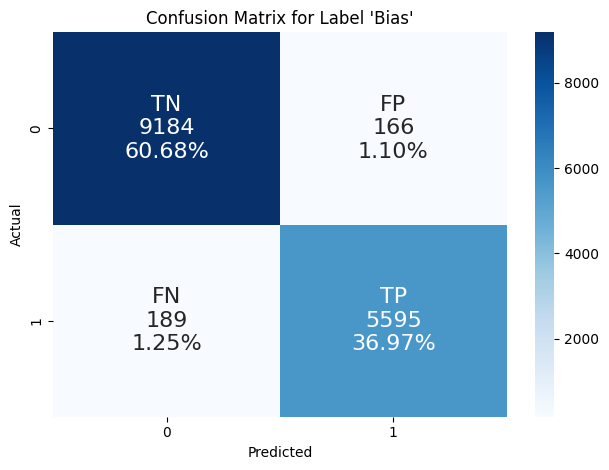

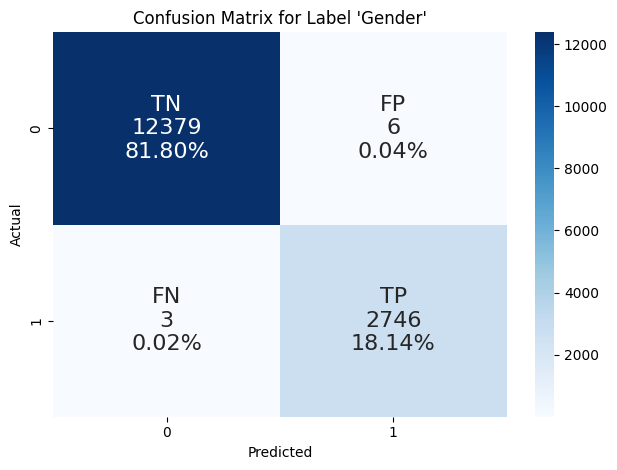

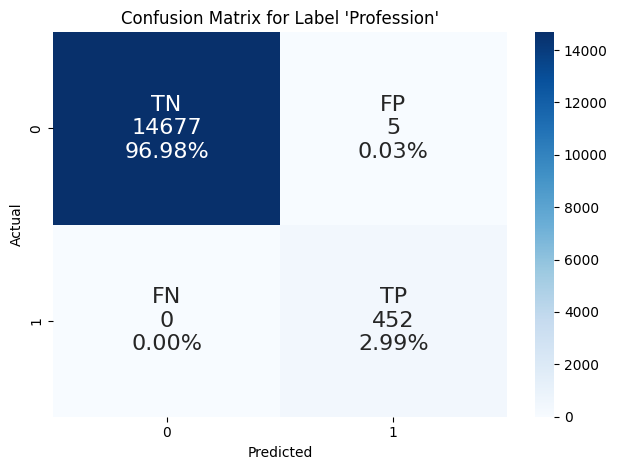

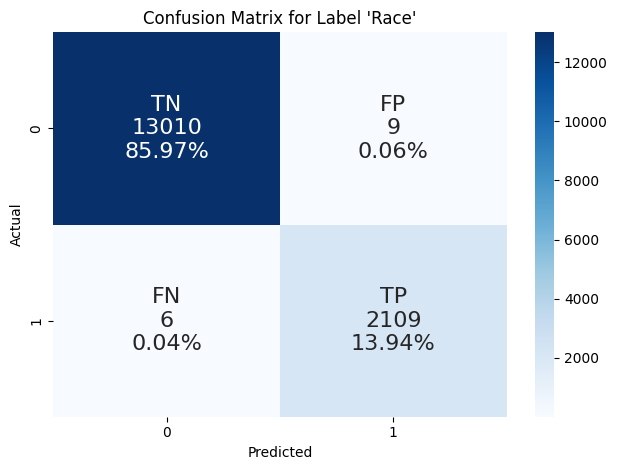

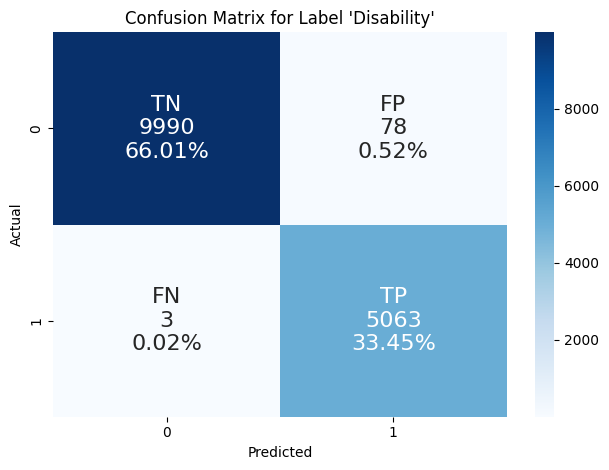

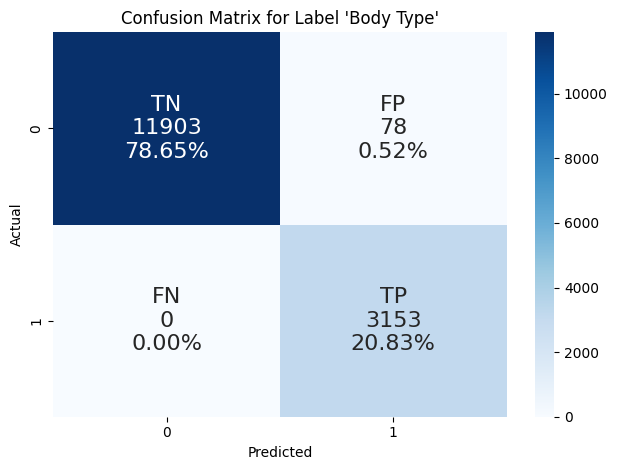

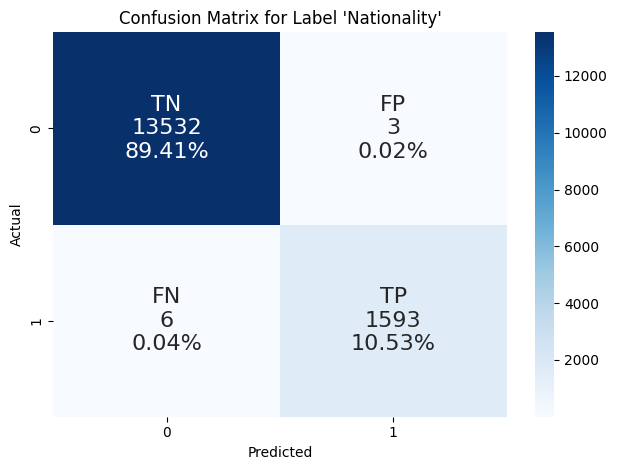

In [80]:
def plot_confusion_matrices(true_labels, predictions):
    # Loop over each label and create a confusion matrix
    for i in range(7):
        # Compute confusion matrix for label i
        cnf = confusion_matrix(true_labels[:, i], predictions[:, i])
        group_names = ['TN','FP','FN','TP']
        group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        # Plot confusion matrix as a heatmap
        sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})
        plt.title(f"Confusion Matrix for Label '{prediction_labels[i]}'")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # Show the plot
        plt.show()

# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_f1)

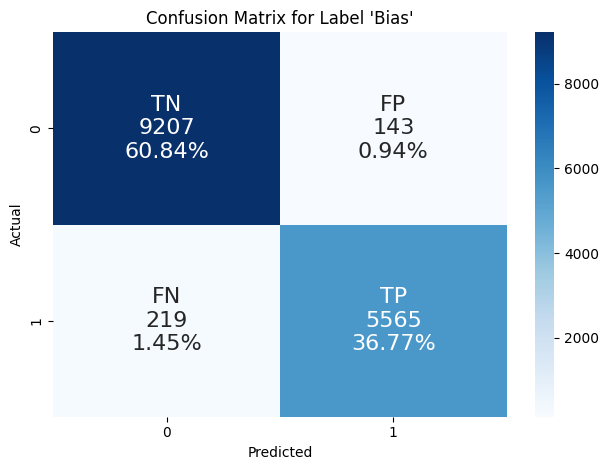

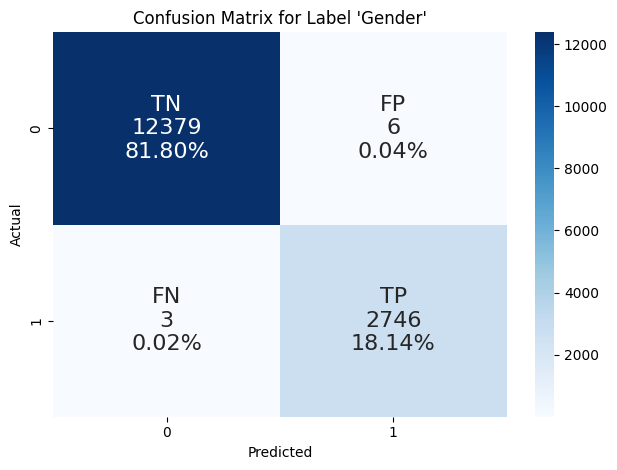

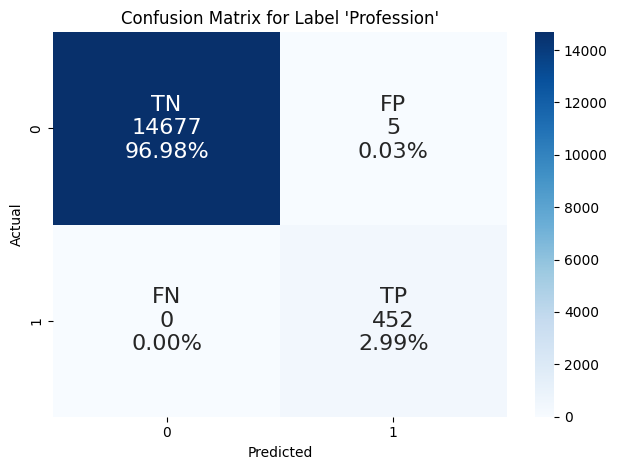

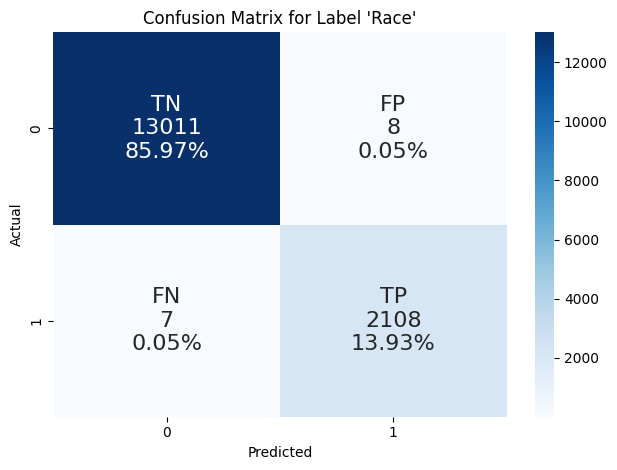

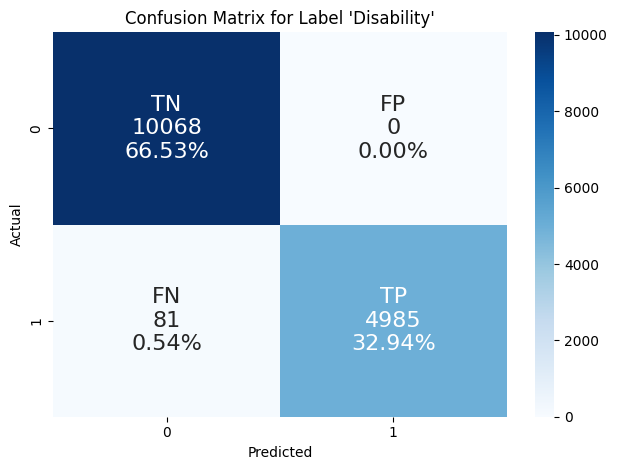

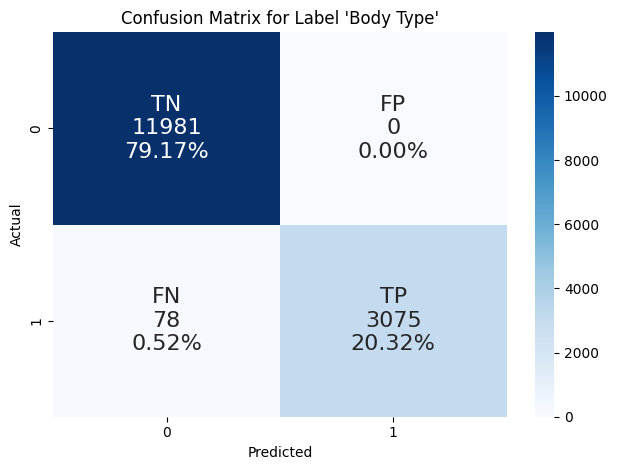

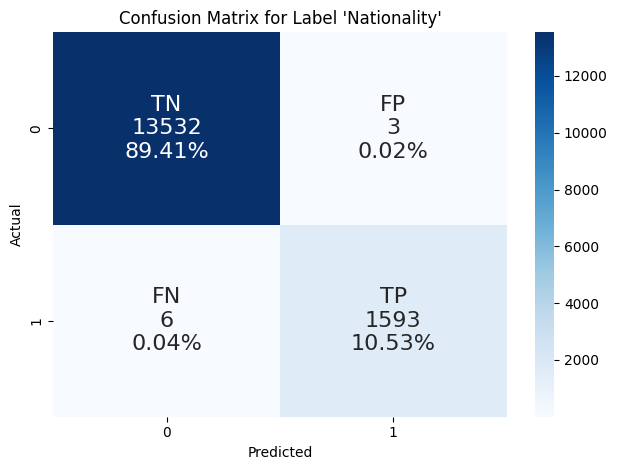

In [81]:
# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_pr_auc)